Conecetando com o Google Drive:

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
# List the content of your local computer folder
!ls -la "/content/gdrive/My Drive/darknet"

In [3]:
!sudo apt-get install tree

In [4]:
!tree /content/gdrive/My\ Drive/darknet/

/content/gdrive/My Drive/darknet/
├── bin
│   └── darknet
└── cuDNN
    ├── cudnn-linux-x86_64-8.9.5.30_cuda12-archive.tar.xz
    └── cudnn-linux-x86_64-8.9.7.29_cuda12-archive.tar.xz

2 directories, 3 files


## Instalando as dependencias:

Checando a versão do CUDA

In [5]:
# This cell can be commented once you checked the current CUDA version
# CUDA: Let's check that Nvidia CUDA is already pre-installed and which version is it. In some time from now maybe you
!/usr/local/cuda/bin/nvcc --version
!cat /etc/os-release


nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0
PRETTY_NAME="Ubuntu 22.04.3 LTS"
NAME="Ubuntu"
VERSION_ID="22.04"
VERSION="22.04.3 LTS (Jammy Jellyfish)"
VERSION_CODENAME=jammy
ID=ubuntu
ID_LIKE=debian
HOME_URL="https://www.ubuntu.com/"
SUPPORT_URL="https://help.ubuntu.com/"
BUG_REPORT_URL="https://bugs.launchpad.net/ubuntu/"
PRIVACY_POLICY_URL="https://www.ubuntu.com/legal/terms-and-policies/privacy-policy"
UBUNTU_CODENAME=jammy


Instalando o cuDNN de versão compativel com a versão do CUDA (você deve baixar a versão correta e salva-la no drive), instale a versão correta [aqui](https://developer.nvidia.com/rdp/cudnn-archive).

In [6]:
# Não esqueça de substituir o arquivo pelo nome correto que você o salvou no drive
!tar -xJvf gdrive/My\ Drive/darknet/cuDNN/cudnn-linux-x86_64-8.9.7.29_cuda12-archive.tar.xz -C /usr/local/
# !ls /usr/local/

Copiando o conteudo para o local correto:

In [7]:
!cp /usr/local/cudnn-linux-x86_64-8.9.7.29_cuda12-archive/include/* /usr/local/cuda/include/
!cp /usr/local/cudnn-linux-x86_64-8.9.7.29_cuda12-archive/lib/* /usr/local/cuda/lib64/
# !ls /usr/local/cuda/include | grep cudnn

## Instalando a rede YOLOv3

Clonando o repositório com da darknet e salvando no drive [comente após a primeira execução].

Antes de executar essa célula tenha certeza que a pasta /darknet/bin foi criada no Drive.

In [8]:
# Comment this code on the future runs.
!git clone https://github.com/kriyeng/darknet/
%cd /content/darknet

# Check the folder
!ls

#Compile Darknet
!make

#Copies the Darknet compiled version to Google drive
!cp ./darknet /content/gdrive/My\ Drive/darknet/bin/darknet

Função para mostrar imagens no notebook:

In [9]:
def imShow(path):
  import cv2
  import matplotlib.pyplot as plt
  %matplotlib inline

  image = cv2.imread(path)
  height, width = image.shape[:2]
  resized_image = cv2.resize(image,(3*width, 3*height), interpolation = cv2.INTER_CUBIC)

  fig = plt.gcf()
  fig.set_size_inches(18, 10)
  plt.axis("off")
  #plt.rcParams['figure.figsize'] = [10, 5]
  plt.imshow(cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB))
  plt.show()

## Testando a rede com um exemplo

Obtendo os pesos pré treinados da rede YOLOv3:

In [12]:
!wget https://pjreddie.com/media/files/yolov3.weights

--2025-01-17 14:31:33--  https://pjreddie.com/media/files/yolov3.weights
Resolving pjreddie.com (pjreddie.com)... 162.0.215.52
Connecting to pjreddie.com (pjreddie.com)|162.0.215.52|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248007048 (237M) [application/octet-stream]
Saving to: ‘yolov3.weights’

yolov3.weights      100%[===================>] 236.52M  29.5MB/s    in 8.0s    

2025-01-17 14:31:41 (29.5 MB/s) - ‘yolov3.weights’ saved [248007048/248007048]



layer     filters    size              input                output
   0 conv     32  3 x 3 / 1   416 x 416 x   3   ->   416 x 416 x  32 0.299 BF
   1 conv     64  3 x 3 / 2   416 x 416 x  32   ->   208 x 208 x  64 1.595 BF
   2 conv     32  1 x 1 / 1   208 x 208 x  64   ->   208 x 208 x  32 0.177 BF
   3 conv     64  3 x 3 / 1   208 x 208 x  32   ->   208 x 208 x  64 1.595 BF
   4 Shortcut Layer: 1
   5 conv    128  3 x 3 / 2   208 x 208 x  64   ->   104 x 104 x 128 1.595 BF
   6 conv     64  1 x 1 / 1   104 x 104 x 128   ->   104 x 104 x  64 0.177 BF
   7 conv    128  3 x 3 / 1   104 x 104 x  64   ->   104 x 104 x 128 1.595 BF
   8 Shortcut Layer: 5
   9 conv     64  1 x 1 / 1   104 x 104 x 128   ->   104 x 104 x  64 0.177 BF
  10 conv    128  3 x 3 / 1   104 x 104 x  64   ->   104 x 104 x 128 1.595 BF
  11 Shortcut Layer: 8
  12 conv    256  3 x 3 / 2   104 x 104 x 128   ->    52 x  52 x 256 1.595 BF
  13 conv    128  1 x 1 / 1    52 x  52 x 256   ->    52 x  52 x 128 0.177 BF
  14 c

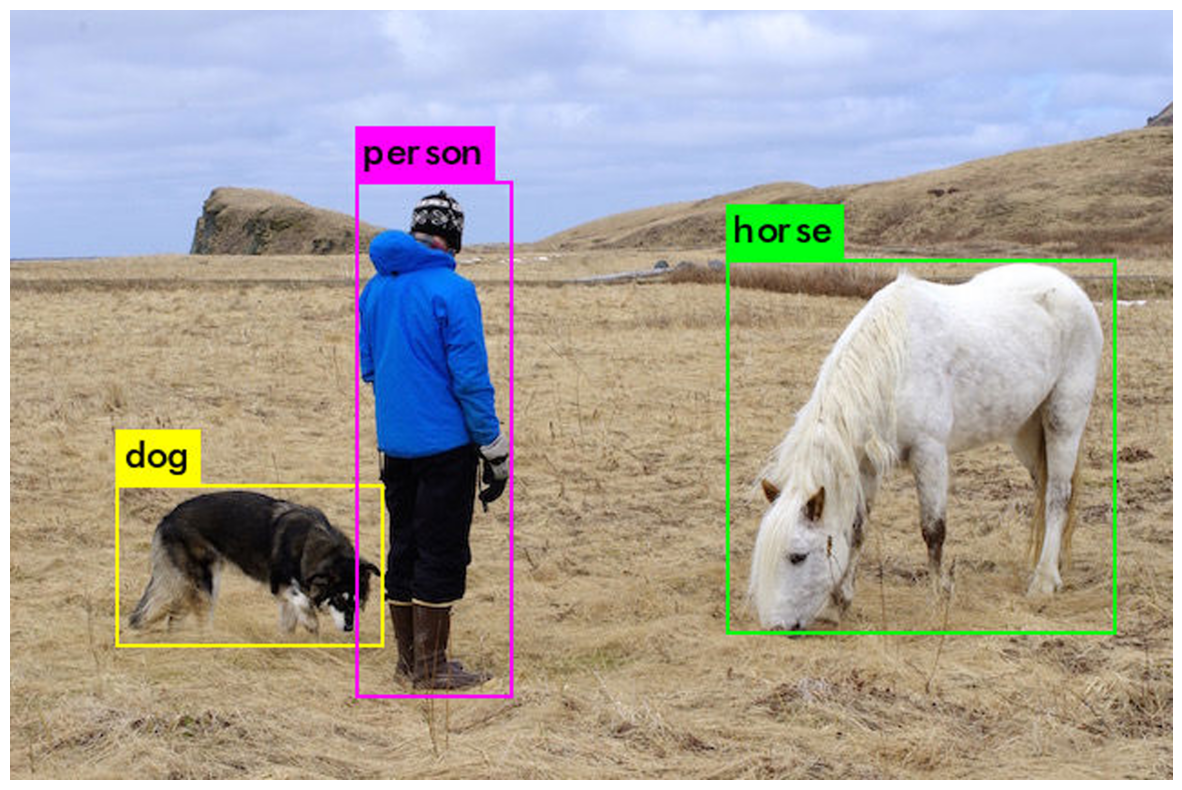

In [13]:
# Execute darknet using YOLOv3 model with pre-trained weights to detect objects on 'person.jpg'
!./darknet detect cfg/yolov3.cfg yolov3.weights data/person.jpg -dont-show

# Show the result using the helper imgShow()
imShow('predictions.jpg')

## Obtendo o dataset da COCO

Criando o diretorio para o dataset:

In [14]:
!mkdir /content/dataset/
%cd /content/dataset/

/content/dataset


Realizando o download do dataset:

In [15]:
!wget http://images.cocodataset.org/zips/train2017.zip
!wget http://images.cocodataset.org/zips/val2017.zip
!wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip

--2025-01-17 14:31:57--  http://images.cocodataset.org/zips/train2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 3.5.25.223, 3.5.8.156, 3.5.12.153, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|3.5.25.223|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19336861798 (18G) [application/zip]
Saving to: ‘train2017.zip’

train2017.zip       100%[===================>]  18.01G  58.5MB/s    in 6m 9s   

2025-01-17 14:38:06 (50.0 MB/s) - ‘train2017.zip’ saved [19336861798/19336861798]

--2025-01-17 14:38:06--  http://images.cocodataset.org/zips/val2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.217.10.12, 52.216.56.1, 3.5.29.116, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|52.217.10.12|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 815585330 (778M) [application/zip]
Saving to: ‘val2017.zip’

val2017.zip         100%[===================>] 777.80M  55.4MB/s   

Descompactando os dados:

In [16]:
!unzip train2017.zip
!unzip val2017.zip
!unzip annotations_trainval2017.zip

In [17]:
# Lendo as classes
with open('/content/darknet/data/coco.names', 'r') as f:
    classes = [line.strip() for line in f.readlines()]

print("Classes do COCO:")
for i, class_name in enumerate(classes):
    print(f"{i}: {class_name}")

Classes do COCO:
0: person
1: bicycle
2: car
3: motorbike
4: aeroplane
5: bus
6: train
7: truck
8: boat
9: traffic light
10: fire hydrant
11: stop sign
12: parking meter
13: bench
14: bird
15: cat
16: dog
17: horse
18: sheep
19: cow
20: elephant
21: bear
22: zebra
23: giraffe
24: backpack
25: umbrella
26: handbag
27: tie
28: suitcase
29: frisbee
30: skis
31: snowboard
32: sports ball
33: kite
34: baseball bat
35: baseball glove
36: skateboard
37: surfboard
38: tennis racket
39: bottle
40: wine glass
41: cup
42: fork
43: knife
44: spoon
45: bowl
46: banana
47: apple
48: sandwich
49: orange
50: broccoli
51: carrot
52: hot dog
53: pizza
54: donut
55: cake
56: chair
57: sofa
58: pottedplant
59: bed
60: diningtable
61: toilet
62: tvmonitor
63: laptop
64: mouse
65: remote
66: keyboard
67: cell phone
68: microwave
69: oven
70: toaster
71: sink
72: refrigerator
73: book
74: clock
75: vase
76: scissors
77: teddy bear
78: hair drier
79: toothbrush


Criando o arquivo de configurações do dataset:

In [18]:
%cd /content/darknet
!echo "classes= 80" > data/coco.data
!echo "train= data/train.txt" >> data/coco.data
!echo "valid= data/val.txt" >> data/coco.data
!echo "names= data/coco.names" >> data/coco.data
!echo "backup= backup/" >> data/coco.data

/content/darknet


## Treinando o modelo

Alterando as configurações da rede para realizar o treinamento:

In [19]:
%cd /content/darknet/cfg
!sed -i 's/batch=1/batch=64/' yolov3.cfg
!sed -i 's/subdivisions=1/subdivisions=16/' yolov3.cfg

!grep "batch=" yolov3.cfg
!grep "subdivisions=" yolov3.cfg

/content/darknet/cfg
batch=64
# batch=64
subdivisions=16
# subdivisions=166


Criando o arquivo train.txt:

In [20]:
import os

train_images_path = "/content/dataset/train2017"
train_txt_path = "/content/darknet/data/train.txt"

# Obter todos os arquivos de imagem no diretório
with open(train_txt_path, "w") as f:
    for image_file in os.listdir(train_images_path):
        if image_file.endswith(".jpg"):  # Verificar se é um arquivo de imagem
            f.write(f"{train_images_path}/{image_file}\n")

print(f"Arquivo train.txt criado em: {train_txt_path}")


Arquivo train.txt criado em: /content/darknet/data/train.txt


In [21]:
%cd /content/darknet/data/
!ls

/content/darknet/data
9k.tree     coco.names	giraffe.jpg  imagenet.labels.list      openimages.names  train.txt
coco9k.map  dog.jpg	goal.txt     imagenet.shortnames.list  person.jpg	 voc.names
coco.data   eagle.jpg	horses.jpg   labels		       scream.jpg


Realizando o treinamento:

In [22]:
%cd /content/darknet/
!./darknet detector train data/coco.data cfg/yolov3.cfg yolov3.weights -dont_show

## Testando o modelo treinado

Imagem de teste obtida de: https://oeco.org.br/noticias/26672-queremos-cidades-para-pessoas-e-cachorros/

layer     filters    size              input                output
   0 conv     32  3 x 3 / 1   416 x 416 x   3   ->   416 x 416 x  32 0.299 BF
   1 conv     64  3 x 3 / 2   416 x 416 x  32   ->   208 x 208 x  64 1.595 BF
   2 conv     32  1 x 1 / 1   208 x 208 x  64   ->   208 x 208 x  32 0.177 BF
   3 conv     64  3 x 3 / 1   208 x 208 x  32   ->   208 x 208 x  64 1.595 BF
   4 Shortcut Layer: 1
   5 conv    128  3 x 3 / 2   208 x 208 x  64   ->   104 x 104 x 128 1.595 BF
   6 conv     64  1 x 1 / 1   104 x 104 x 128   ->   104 x 104 x  64 0.177 BF
   7 conv    128  3 x 3 / 1   104 x 104 x  64   ->   104 x 104 x 128 1.595 BF
   8 Shortcut Layer: 5
   9 conv     64  1 x 1 / 1   104 x 104 x 128   ->   104 x 104 x  64 0.177 BF
  10 conv    128  3 x 3 / 1   104 x 104 x  64   ->   104 x 104 x 128 1.595 BF
  11 Shortcut Layer: 8
  12 conv    256  3 x 3 / 2   104 x 104 x 128   ->    52 x  52 x 256 1.595 BF
  13 conv    128  1 x 1 / 1    52 x  52 x 256   ->    52 x  52 x 128 0.177 BF
  14 c

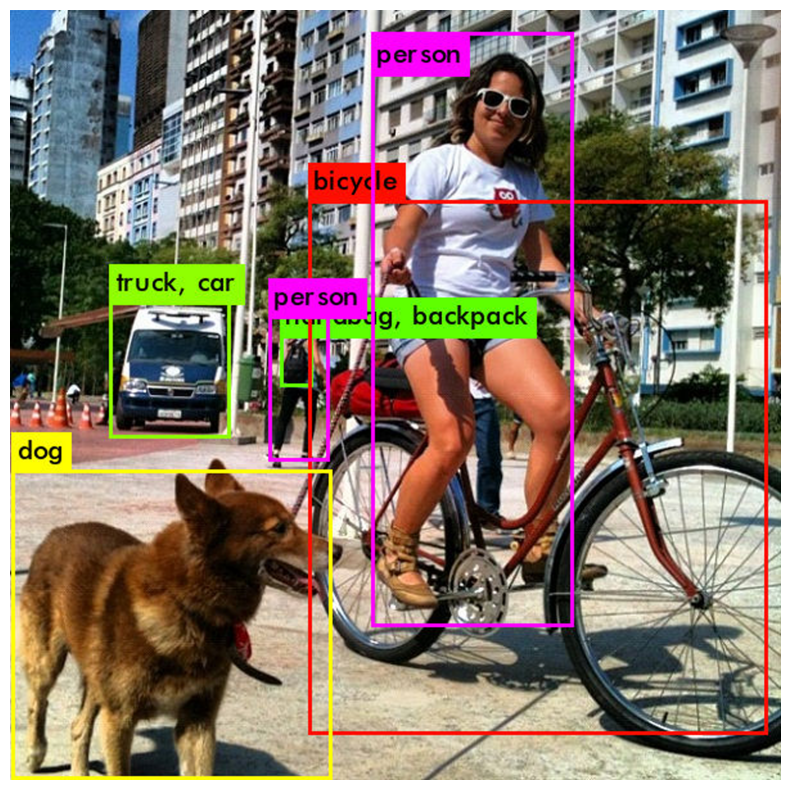

In [24]:
!./darknet detector test data/coco.data cfg/yolov3.cfg backup/yolov3_final.weights /content/teste.jpg
imShow('predictions.jpg')